### Membuat Spark Context untuk aplikasi Spotiplay

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import current_timestamp

spark = SparkSession.builder \
    .appName("SpotifyStreaming") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.1,org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5") \
    .config("spark.kafka.consumer.properties", "partition.assignment.strategy=range") \
    .getOrCreate()

In [2]:
print(spark.sparkContext.getConf().get('spark.jars'))

file:///home/bigdata/.ivy2/jars/org.mongodb.spark_mongo-spark-connector_2.11-2.4.1.jar,file:///home/bigdata/.ivy2/jars/org.apache.spark_spark-sql-kafka-0-10_2.11-2.4.5.jar,file:///home/bigdata/.ivy2/jars/org.mongodb_mongo-java-driver-3.10.2.jar,file:///home/bigdata/.ivy2/jars/org.apache.kafka_kafka-clients-2.0.0.jar,file:///home/bigdata/.ivy2/jars/org.spark-project.spark_unused-1.0.0.jar,file:///home/bigdata/.ivy2/jars/org.lz4_lz4-java-1.4.0.jar,file:///home/bigdata/.ivy2/jars/org.xerial.snappy_snappy-java-1.1.7.3.jar,file:///home/bigdata/.ivy2/jars/org.slf4j_slf4j-api-1.7.16.jar


### Get From parquet

In [3]:
df = spark.read.parquet("/home/bigdata/spotiplay/data")
df.createOrReplaceTempView("songs")
df = df.sort("timestamp", ascending=True)
df.show()

+--------------------+--------------------+-----------+--------------------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+
|            track_id|          track_name|artist_name|         album_image|danceability|energy|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|           timestamp|
+--------------------+--------------------+-----------+--------------------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+
|1m4mmA1KS5eV6RQlo...|Santa wa chuo-sen...|       null|https://i.scdn.co...|       0.695| 0.381|    -9.7| 0.0|     0.0295|      0.0337|         1.66E-4|   0.251|  0.714| 75.063|2023-03-21 07:49:...|
|2SmryvmzCMHQ4fjAf...|   Kamu Kurang Usaha|       null|https://i.scdn.co...|       0.426| 0.513|  -7.504| 1.0|     0.0366|       0.681|             0.0|  0.0801|   0.11|135.947|2023-03-21 07:49:...|
|3i0h

In [4]:
mongo_uri = "mongodb://localhost:27017/spotiplay.tracks"
mongo_conf = {"spark.mongodb.input.uri": mongo_uri}
df_tracks = spark.read.format("com.mongodb.spark.sql.DefaultSource") \
             .options(**mongo_conf) \
             .load()
             
df_tracks.createOrReplaceTempView("tracks")
df_tracks.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------+--------+--------------+--------------------+--------------------+--------------------+--------+--------------------+----------+--------------------+------------+-----+--------------------+
|                 _id|               album|             artists|      audio_features|   available_markets|disc_number|duration_ms|explicit|  external_ids|       external_urls|                href|                  id|is_local|                name|popularity|         preview_url|track_number| type|                 uri|
+--------------------+--------------------+--------------------+--------------------+--------------------+-----------+-----------+--------+--------------+--------------------+--------------------+--------------------+--------+--------------------+----------+--------------------+------------+-----+--------------------+
|[641f7d7b6ef712a9...|[album, album, [[.

In [5]:
from pyspark.sql.functions import col

df_features = df_tracks.select(col("name"), 
                               col("artists").getItem("name").alias("artists"),
                               col("audio_features").getItem("danceability").alias("danceability"), 
                               col("audio_features").getItem("energy").alias("energy"), 
                               col("audio_features").getItem("loudness").alias("loudness"), 
                               col("audio_features").getItem("speechiness").alias("speechiness"), 
                               col("audio_features").getItem("acousticness").alias("acousticness"), 
                               col("audio_features").getItem("instrumentalness").alias("instrumentalness"), 
                               col("audio_features").getItem("liveness").alias("liveness"), 
                               col("audio_features").getItem("valence").alias("valence"), 
                               col("audio_features").getItem("tempo").alias("tempo"), )

df_features.show()

+--------------------+--------------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+
|                name|             artists|danceability|energy|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|
+--------------------+--------------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+
|       Liburan Indie|     [Endah N Rhesa]|       0.807| 0.271|  -8.427|     0.0385|       0.883|         1.76E-6|   0.118|  0.753|109.941|
|            Menganga|          [Pas Band]|        0.25| 0.842|   -6.48|     0.0563|     6.32E-4|           0.691|   0.076|  0.358|161.955|
|       Singomenggolo|          [Pas Band]|       0.269| 0.914|  -7.436|     0.0931|     0.00196|         0.00212|   0.174|  0.402|164.445|
|              Solusi|          [Pas Band]|       0.306| 0.796|  -8.703|     0.0517|      0.0015|           0.641|  0.0902|  0.392|163.308|
|Schiebung Des Mad..

In [6]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['danceability', 'energy', 'loudness', 'speechiness', 
               'acousticness', 'instrumentalness', 'liveness', 
               'valence', 'tempo'], 
    outputCol='features'
)

assembled_data = assembler.setHandleInvalid("skip").transform(df_features)

from pyspark.ml.feature import StandardScaler
scale = StandardScaler(
    inputCol='features', 
    outputCol='standardized'
)

data_scale = scale.fit(assembled_data)
df_scaled = data_scale.transform(assembled_data)


K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9


In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

silhouette_score = []
evaluator = ClusteringEvaluator(
    predictionCol='prediction', 
    featuresCol='standardized', 
    metricName='silhouette', 
    distanceMeasure='squaredEuclidean'
)

for k in range(2, 10):
    print("K = {}".format(k))
    kmeans = KMeans(
        featuresCol='standardized', 
        predictionCol='prediction', 
        k=k, 
        seed=1
    )
    pipeline = Pipeline(stages=[kmeans])
    model = pipeline.fit(df_scaled)
    predictions = model.transform(df_scaled)
    silhouette_score.append(evaluator.evaluate(predictions))

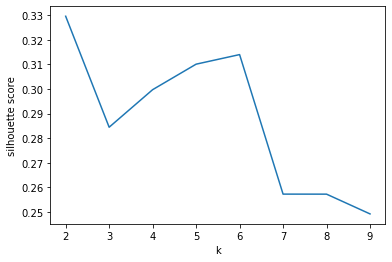

In [19]:
import matplotlib.pyplot as plt
plt.plot(range(2, 10), silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.show()

K = 2
K = 3
K = 4
K = 5
K = 6
K = 7
K = 8
K = 9


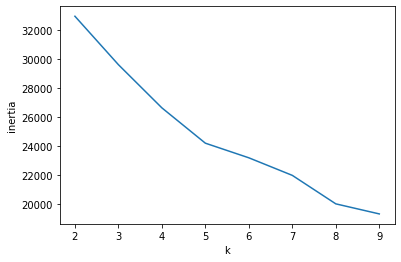

In [8]:
#elbow method
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

inertias = []

for k in range(2, 10):
    print("K = {}".format(k))
    kmeans = KMeans(
        featuresCol='standardized', 
        predictionCol='prediction', 
        k=k, 
        seed=1
    )
    model = kmeans.fit(df_scaled)
    inertias.append(model.computeCost(df_scaled))
    
import matplotlib.pyplot as plt
plt.plot(range(2, 10), inertias)
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

In [20]:
#use k=5
kmeans = KMeans(
    featuresCol='standardized',
    predictionCol='prediction',
    k=5,
    seed=1
)

pipeline = Pipeline(stages=[assembler, scale, kmeans])

model = pipeline.fit(df_features)

output_df = model.transform(df_features)
 

In [40]:
output_df.show()
    
#save data to parquet
output_df.write.parquet("/home/bigdata/spotiplay/tracks_clustered")
 

+--------------------+--------------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+----------+
|                name|             artists|danceability|energy|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|            features|        standardized|prediction|
+--------------------+--------------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+----------+
|       Liburan Indie|     [Endah N Rhesa]|       0.807| 0.271|  -8.427|     0.0385|       0.883|         1.76E-6|   0.118|  0.753|109.941|[0.807,0.271,-8.4...|[5.49196503063483...|         0|
|            Menganga|          [Pas Band]|        0.25| 0.842|   -6.48|     0.0563|     6.32E-4|           0.691|   0.076|  0.358|161.955|[0.25,0.842,-6.48...|[1.70135223997361...|         1|
|       Singomenggolo|          [Pa

In [22]:
df.show()

+--------------------+--------------------+-------+--------------------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+
|            track_id|                name|artists|         album_image|danceability|energy|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|           timestamp|
+--------------------+--------------------+-------+--------------------+------------+------+--------+----+-----------+------------+----------------+--------+-------+-------+--------------------+
|1m4mmA1KS5eV6RQlo...|Santa wa chuo-sen...|   null|https://i.scdn.co...|       0.695| 0.381|    -9.7| 0.0|     0.0295|      0.0337|         1.66E-4|   0.251|  0.714| 75.063|2023-03-21 07:49:...|
|2SmryvmzCMHQ4fjAf...|   Kamu Kurang Usaha|   null|https://i.scdn.co...|       0.426| 0.513|  -7.504| 1.0|     0.0366|       0.681|             0.0|  0.0801|   0.11|135.947|2023-03-21 07:49:...|
|3i0h88q1HBtbdIg2b...|   

In [23]:
#rename df.track_name to df.name
df = df.withColumnRenamed("track_name", "name")
df = df.withColumnRenamed("artist_name", "artists")

cols = ['name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

cols_drop = ['track_id','album_image','timestamp','mode']

df_new = df.drop(*cols_drop)

df_new.show()

+--------------------+-------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+
|                name|artists|danceability|energy|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|
+--------------------+-------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+
|Santa wa chuo-sen...|   null|       0.695| 0.381|    -9.7|     0.0295|      0.0337|         1.66E-4|   0.251|  0.714| 75.063|
|   Kamu Kurang Usaha|   null|       0.426| 0.513|  -7.504|     0.0366|       0.681|             0.0|  0.0801|   0.11|135.947|
|       Tertawan Hati|   null|       0.319| 0.432|  -5.831|     0.0317|       0.661|             0.0|   0.108|  0.244|128.244|
|Jangan Cepat Berlalu|   null|       0.509| 0.264| -11.505|     0.0294|       0.915|         1.46E-4|   0.157|    0.3|133.938|
|         Asmalibrasi|   null|       0.721| 0.565|  -6.208|     0.0292|       0.855|         5.48E-6|  0.0973| 

In [24]:
df_latest_song = pipeline.fit(df_new).transform(df_new)

df_predict = df_latest_song.select("name", "artists", "prediction")

df_predict.show()

+--------------------+-------+----------+
|                name|artists|prediction|
+--------------------+-------+----------+
|Santa wa chuo-sen...|   null|         0|
|                Muak|   null|         2|
|           Sisa Rasa|   null|         4|
|         Asmalibrasi|   null|         0|
|Jangan Cepat Berlalu|   null|         4|
|  Hingga Tua Bersama|   null|         4|
|              Lantas|   null|         2|
|   Kamu Kurang Usaha|   null|         4|
|       Tertawan Hati|   null|         4|
| Cassette Tape Dream|   null|         3|
|   Tak Segampang Itu|   null|         4|
|              Komang|   null|         4|
|Jinro no tame no ...|   null|         1|
|Lo-fi shojo wa ky...|   null|         2|
| Cassette Tape Dream|   null|         3|
|Santa wa chuo-sen...|   null|         0|
|Jinro no tame no ...|   null|         1|
|Jinro no tame no ...|   null|         1|
|                 10C|   null|         0|
|                Usai|   null|         4|
+--------------------+-------+----

In [25]:
#show the songs in the same cluster
output_df.filter(output_df.prediction == 2).limit(5).show()

+--------------------+--------------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+----------+
|                name|             artists|danceability|energy|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|            features|        standardized|prediction|
+--------------------+--------------------+------------+------+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+----------+
|          Perjalanan|          [Pas Band]|       0.539|  0.78|  -8.446|     0.0764|     0.00157|         0.00283|  0.0532|   0.67|115.533|[0.539,0.78,-8.44...|[3.66811542938311...|         2|
|Liburan Indie - Live|     [Endah N Rhesa]|       0.618| 0.354|  -7.313|      0.102|       0.832|         1.39E-5|   0.566|  0.919|117.806|[0.618,0.354,-7.3...|[4.20574273721477...|         2|
|             Eternal|        [Indi

In [26]:
from pyspark.sql.functions import to_json, struct

# Convert data frame to JSON string
df_predict_json = df_predict.select(to_json(struct("*")).alias("value"))


# Write data frame to Kafka topic
df_predict_json.write.format("kafka") \
    .option("kafka.bootstrap.servers", "localhost:9092") \
    .option("topic", "recommendations") \
    .save()

In [27]:
from pyspark.mllib.linalg import Vectors
#import numpy
import numpy as np
#import to_json
from pyspark.sql.functions import to_json, struct
def euclidean_distance(x, y):
    distance = np.linalg.norm(np.array(x) - np.array(y))
    distance_in_int = int(distance * 100000)
    return distance_in_int

def spotify_recommendations(row,num_recommendations=5):
    # create a list to store the recommendations
    recommendations = []
    latest_song_name = row['name']
    latest_song_cluster = row['prediction']
    latest_song_features = row['standardized']

    # filter the music_database RDD to only include songs in the same cluster as the latest_song
    music_database_filtered = music_database.filter(lambda x: x[2] == latest_song_cluster)

    # calculate the Euclidean distance between latest_song and each song in music_database_filtered
    music_database_distances = music_database_filtered.map(lambda x: (x[0], euclidean_distance(x[1], latest_song_features)))

    # sort music_database_distances by distance in ascending order
    music_database_sorted = music_database_distances.sortBy(lambda x: x[1], ascending=True)
    
    #remove duplicate songs from the list
    music_database_sorted = music_database_sorted.reduceByKey(lambda x, y: x)

    # get the top 5 songs
    recommendations_temp = music_database_sorted.take(num_recommendations)

    # add the recommendations to the recommendations list
    recommendations.extend([(recommendation[0], recommendation[1]) for recommendation in recommendations_temp])

    return recommendations

music_database = output_df.rdd.map(lambda x: (x['name'], x['standardized'], x['prediction']))
# foreachBatch() will apply the function to each batch of data
random_df = df_latest_song.toPandas()

sample_df = random_df.sample(n=1)

for index, row in sample_df.iterrows():
    random_row = row
    print(random_row)
    recommendations = spotify_recommendations(random_row,5)
    print(recommendations)
    recommendations_df = spark.createDataFrame(recommendations, ['name', 'distance'])
    
    kafka_df = recommendations_df.select(to_json(struct("*")).alias("value"))
    kafka_df.write.format("kafka") \
        .option("kafka.bootstrap.servers", "localhost:9092") \
        .option("topic", "recommendations") \
        .save()

name                                                           Komang
artists                                                          None
danceability                                                    0.696
energy                                                          0.412
loudness                                                       -8.547
speechiness                                                     0.027
acousticness                                                    0.415
instrumentalness                                             6.16e-05
liveness                                                          0.1
valence                                                         0.349
tempo                                                         133.913
features            [0.696, 0.412, -8.547, 0.027, 0.415, 6.16e-05,...
standardized        [4.545525991766931, 2.2561014359678704, -1.777...
prediction                                                          4
Name: 11, dtype: obj

In [32]:
print(model)

PipelineModel_86bdb5e1ce9c


In [ ]:
#save model to local
model.save("model")

#copy model to hdfs and overwrite
!hdfs dfs -copyFromLocal -f model hdfs://localhost:9000/user/model

In [38]:
from pyspark.ml import PipelineModel

#load model from hdfs
model = PipelineModel.load("model")

In [16]:
sc.stop()
ssc.stop()

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import current_timestamp
from pyspark.sql.functions import concat, col, lit
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pyspark.ml import PipelineModel
from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import to_json, struct
import numpy as np
#pandas for time series
import pandas as pd
#time for counting time
import time
# Define the schema for the streaming DataFrame
schema = StructType([
    StructField("track_id", StringType()),
    StructField("track_name", StringType()),
    StructField("artist_name", StringType()),
    StructField("album_image", StringType()),
    StructField("danceability", DoubleType()),
    StructField("energy", DoubleType()),
    StructField("loudness", DoubleType()),
    StructField("mode", DoubleType()),
    StructField("speechiness", DoubleType()),
    StructField("acousticness", DoubleType()),
    StructField("instrumentalness", DoubleType()),
    StructField("liveness", DoubleType()),
    StructField("valence", DoubleType()),
    StructField("tempo", DoubleType())
])

spark = SparkSession.builder \
    .appName("SpotifyStreaming") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.1,org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5") \
    .config("spark.kafka.consumer.properties", "partition.assignment.strategy=range") \
    .getOrCreate()
    
sc = spark.sparkContext

def euclidean_distance(x, y):
    """Calculate the Euclidean distance between two vectors."""
    distance = np.linalg.norm(np.array(x) - np.array(y))
    distance_in_int = int(distance * 100000)
    return distance_in_int


def get_recommendations(row, num_recommendations=5):
    spark2 = SparkSession.builder.appName("NewSpotifyStreaming2").getOrCreate()
    sc2= spark2.sparkContext
    ssc2 = StreamingContext(sc2, 10)
    ssc2.checkpoint("./checkpoint")
    
    output_df = spark2.read.parquet("/home/bigdata/spotiplay/tracks_clustered")
    music_database = output_df.rdd.map(lambda x: (x['name'], x['standardized'], x['prediction']))
    
    recommendations = []
    latest_song_name = row['track_name']
    latest_song_cluster = row['prediction']
    latest_song_features = row['standardized']

    # filter the music_database RDD to only include songs in the same cluster as the latest_song
    music_database_filtered = music_database.filter(lambda x: x[2] == latest_song_cluster)
    
    #filter the music not same as latest song
    music_database_filtered = music_database_filtered.filter(lambda x: x[0] != latest_song_name)

    # calculate the Euclidean distance between latest_song and each song in music_database_filtered
    music_database_distances = music_database_filtered.map(lambda x: (x[0], euclidean_distance(x[1], latest_song_features)))

    # sort music_database_distances by distance in ascending order
    music_database_sorted = music_database_distances.sortBy(lambda x: x[1], ascending=True)

    # remove duplicate songs from the list
    music_database_sorted = music_database_sorted.reduceByKey(lambda x, y: x)

    # get the top 5 songs
    recommendations_temp = music_database_sorted.take(num_recommendations)

    # add the recommendations to the recommendations list
    recommendations.extend([(recommendation[0], recommendation[1]) for recommendation in recommendations_temp])

    return recommendations

# create a Spark Streaming context with a batch interval of 10 seconds
ssc = StreamingContext(sc, 10)
ssc.checkpoint("./checkpoint")

# create a DStream that reads from Kafka
KAFKA_TOPIC = "latest_tracks"
BOOTSTRAP_SERVER = "localhost:9092"
songs = KafkaUtils.createDirectStream(ssc, [KAFKA_TOPIC],
                                      {"metadata.broker.list": BOOTSTRAP_SERVER})

#dataframe for counting time
df_wcluster = pd.DataFrame(columns=['index','time'])

def process(rdd):
    if rdd.isEmpty():
        print("RDD is empty")
    else:
        #time for counting time
        start_time = time.time()
        spark1 = SparkSession.builder.appName("NewSpotifyStreaming").getOrCreate()
        sc1= spark1.sparkContext
        ssc1 = StreamingContext(sc1, 10)
        ssc1.checkpoint("./checkpoint")
        print("========Streaming Input==========")

        json_df = spark1.read.json(rdd.map(lambda x: x[1]))
        cols = ['name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
        cols_drop = ['track_id','album_image','timestamp','mode']
        latest = json_df.drop(*cols_drop)
        
        
        print(latest.show())
        
        # load the model from HDFS
        model = PipelineModel.load("model")
        transformed_df = model.transform(latest)
        transformed_df = transformed_df.toPandas()
        random_song = transformed_df.sample(n=1)
        random_song = random_song.to_dict('records')[0]
        recommendations = get_recommendations(random_song,5)
        recommendations_df = spark1.createDataFrame(recommendations, ['name', 'distance'])
        name = random_song['track_name']
        #add the random song name to the recommendations for key
        recommendations_df = recommendations_df.withColumn('key', lit(name))
        recommendations_df = recommendations_df \
            .withColumn("value", to_json(struct([col(x) for x in recommendations_df.columns]))) \
            .select("value")
    
        print(recommendations_df.show())
        
        #send to kafka again
        recommendations_df.write \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "localhost:9092") \
            .option("topic", "recommendations") \
            .save()
            
        #time for counting time
        end_time = time.time()
        time_taken = end_time - start_time
        print("Time taken: ", time_taken)
        #append to dataframe
        df_wcluster.loc[len(df_wcluster)] = [len(df_wcluster), time_taken] 

result = songs.foreachRDD(process)

#count average of each feature
def average_feature(rdd):
    if rdd.isEmpty():
        print("RDD is empty")
    else:
        spark3 = SparkSession.builder.appName("NewSpotifyStreaming3").getOrCreate()
        sc3= spark3.sparkContext
        ssc3 = StreamingContext(sc3, 10)
        ssc3.checkpoint("./checkpoint")
        print("========Streaming Input==========")
        json_df = spark3.read.json(rdd.map(lambda x: x[1]))
        cols = ['name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']
        cols_drop = ['track_id','album_image','timestamp','mode']
        latest = json_df.drop(*cols_drop)
        latest = latest.toPandas()
        #average of each feature
        average_danceability = latest['danceability'].mean()
        average_energy = latest['energy'].mean()
        average_loudness = latest['loudness'].mean()
        average_speechiness = latest['speechiness'].mean()
        average_acousticness = latest['acousticness'].mean()
        average_instrumentalness = latest['instrumentalness'].mean()
        average_liveness = latest['liveness'].mean()
        average_valence = latest['valence'].mean()
        average_tempo = latest['tempo'].mean()
        #append to dataframe
        #create dataframe
        df_characteristic = pd.DataFrame(columns=['index','danceability','energy','loudness','speechiness','acousticness','instrumentalness','liveness','valence','tempo'])
        df_characteristic.loc[len(df_characteristic)] = [len(df_characteristic), average_danceability, average_energy, average_loudness, average_speechiness, average_acousticness, average_instrumentalness, average_liveness, average_valence, average_tempo]
        #send to kafka again
        df_characteristic = spark3.createDataFrame(df_characteristic)
        df_characteristic = df_characteristic \
            .withColumn("value", to_json(struct([col(x) for x in df_characteristic.columns]))) \
            .select("value")
        df_characteristic.write \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "localhost:9092") \
            .option("topic", "characteristic") \
            .save()
        
character = songs.foreachRDD(average_feature)
ssc.start()
ssc.awaitTermination()

RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
========Streaming Input==========
+------------+---------------+------------+------+----------------+--------+--------+-----------+-------+--------------------+-------+
|acousticness|         artist|danceability|energy|instrumentalness|liveness|loudness|speechiness|  tempo|          track_name|valence|
+------------+---------------+------------+------+----------------+--------+--------+-----------+-------+--------------------+-------+
|       0.921|Prinsa Mandagie|       0.509| 0.233|         2.31E-4|   0.113| -10.742|     0.0284|105.944|Sahabat Dulu - Fr...|  0.328|
|       0.652|    Juicy Luicy|       0.459| 0.377|             0.0|  0.0947|  -9.024|     0.0314|169.896|              Tampar|  0.433|
|         0.5|       しゃろう|       0.702|   0.4|          0.0258|   0.131| -10.849|      0.416| 80.004|          You and Me|  0.881|
|        0.89|       Mahalini|       0.563| 0.431|          2.9E-6|   0.123|  -6.7

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql.functions import current_timestamp
from pyspark.sql.functions import concat, col, lit
from pyspark.streaming import StreamingContext
from pyspark.streaming.kafka import KafkaUtils
from pyspark.ml import PipelineModel
from pyspark.mllib.linalg import Vectors
from pyspark.sql.functions import to_json, struct
import numpy as np
import pandas as pd
import time

schema = StructType([
    StructField("track_id", StringType()),
    StructField("track_name", StringType()),
    StructField("artist_name", StringType()),
    StructField("album_image", StringType()),
    StructField("danceability", DoubleType()),
    StructField("energy", DoubleType()),
    StructField("loudness", DoubleType()),
    StructField("mode", DoubleType()),
    StructField("speechiness", DoubleType()),
    StructField("acousticness", DoubleType()),
    StructField("instrumentalness", DoubleType()),
    StructField("liveness", DoubleType()),
    StructField("valence", DoubleType()),
    StructField("tempo", DoubleType())
])

spark = SparkSession.builder \
    .appName("SpotifyStreaming") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.11:2.4.1,org.apache.spark:spark-sql-kafka-0-10_2.11:2.4.5") \
    .config("spark.kafka.consumer.properties", "partition.assignment.strategy=range") \
    .getOrCreate()
    
sc = spark.sparkContext

def euclidean_distance(x, y):
    distance = np.linalg.norm(np.array(x) - np.array(y))
    distance_in_int = int(distance * 100000)
    return distance_in_int


def get_recommendations(row, num_recommendations=5):
    spark2 = SparkSession.builder.appName("NewSpotifyStreaming2").getOrCreate()
    sc2= spark2.sparkContext
    ssc2 = StreamingContext(sc2, 10)
    ssc2.checkpoint("./checkpoint")
    
    output_df = spark2.read.parquet("/home/bigdata/spotiplay/tracks_clustered")
    music_database = output_df.rdd.map(lambda x: (x['name'], x['standardized'], x['prediction']))
    
    recommendations = []
    latest_song_name = row['track_name']
    latest_song_cluster = row['prediction']
    latest_song_features = row['standardized']
    
    print(latest_song_name)
    #filter the music not same as latest song
    music_database_filtered = music_database.filter(lambda x: x[0] != latest_song_name)

    # calculate the Euclidean distance between latest_song and each song in music_database_filtered
    music_database_distances = music_database_filtered.map(lambda x: (x[0], euclidean_distance(x[1], latest_song_features)))

    # sort music_database_distances by distance in ascending order
    music_database_sorted = music_database_distances.sortBy(lambda x: x[1], ascending=True)

    # remove duplicate songs from the list
    music_database_sorted = music_database_sorted.reduceByKey(lambda x, y: x)

    # get the top 5 songs
    recommendations_temp = music_database_sorted.take(num_recommendations)

    # add the recommendations to the recommendations list
    recommendations.extend([(recommendation[0], recommendation[1]) for recommendation in recommendations_temp])

    return recommendations

# create a Spark Streaming context with a batch interval of 10 seconds
ssc = StreamingContext(sc, 10)
ssc.checkpoint("./checkpoint")

# create a DStream that reads from Kafka
KAFKA_TOPIC = "latest_tracks"
BOOTSTRAP_SERVER = "localhost:9092"
songs = KafkaUtils.createDirectStream(ssc, [KAFKA_TOPIC],
                                      {"metadata.broker.list": BOOTSTRAP_SERVER})

#dataframe for counting time
df_wtcluster = pd.DataFrame(columns=['index','time'])

def process(rdd):
    """
    Process each RDD in the DStream.

    Parameters:
    rdd (RDD): The RDD to be processed.
    """
    if rdd.isEmpty():
        print("RDD is empty")
    else:
        #time for counting time
        start_time = time.time()
        spark1 = SparkSession.builder.appName("NewSpotifyStreaming").getOrCreate()
        sc1= spark1.sparkContext
        ssc1 = StreamingContext(sc1, 10)
        ssc1.checkpoint("./checkpoint")

        print("========Streaming Input==========")

        json_df = spark1.read.json(rdd.map(lambda x: x[1]))
        cols = ['name', 'artists', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']

        cols_drop = ['track_id','album_image','timestamp','mode']

        latest = json_df.drop(*cols_drop)
        
        
        print(latest.show())
        
        # load the model from HDFS
        model = PipelineModel.load("model")
        
        transformed_df = model.transform(latest)
        
        transformed_df = transformed_df.toPandas()
        
        random_song = transformed_df.sample(n=1)
        
        random_song = random_song.to_dict('records')[0]
        
        recommendations = get_recommendations(random_song,5)
        
        recommendations_df = spark1.createDataFrame(recommendations, ['name', 'distance'])
        
        name = random_song['track_name']
        
        #add the random song name to the recommendations
        recommendations_df = recommendations_df.withColumn('key', lit(name))
        
        recommendations_df = recommendations_df \
            .withColumn("value", to_json(struct([col(x) for x in recommendations_df.columns]))) \
            .select("value")
    
        print(recommendations_df.show())
        
        #to kafka again
        recommendations_df.write \
            .format("kafka") \
            .option("kafka.bootstrap.servers", "localhost:9092") \
            .option("topic", "recommendations") \
            .save()
            
        #time for counting time
        end_time = time.time()
        time_taken = end_time - start_time
        print("Time taken: ", time_taken)
        #append to dataframe
        df_wtcluster.loc[len(df_wtcluster)] = [len(df_wtcluster), time_taken]
    

result = songs.foreachRDD(process)
ssc.start()
ssc.awaitTermination()

In [2]:
df_wcluster

,index,time
0,0.0,30.495745
1,1.0,6.758468
2,2.0,6.604296
3,3.0,5.795849
4,4.0,5.401968


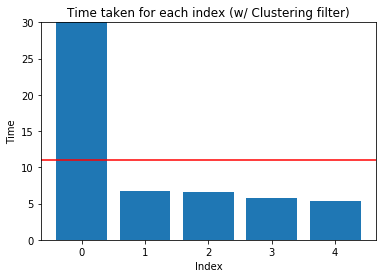

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
# df_wcluster.to_csv('time_wcluster.csv', index=False)
df_wcluster = pd.read_csv('time_wcluster.csv')
 #use this to plot the time taken for each index with bar chart
plt.bar(df_wcluster['index'], df_wcluster['time'])
plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Time taken for each index (w/ Clustering filter)')
plt.ylim(0,30)
#add line for average time
plt.axhline(y=df_wcluster['time'].mean(), color='r', linestyle='-')
plt.show()

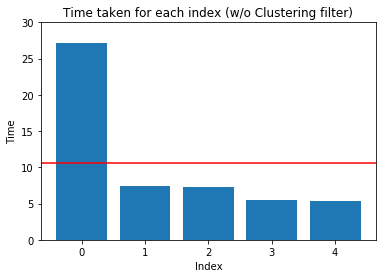

RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty
RDD is empty


In [6]:
#save the dataframe to csv
# df_wtcluster.to_csv('time_wtcluster.csv', index=False)
df_wtcluster = pd.read_csv('time_wtcluster.csv')
plt.bar(df_wtcluster['index'], df_wtcluster['time'])
plt.xlabel('Index')
plt.ylabel('Time')
plt.title('Time taken for each index (w/o Clustering filter)')
#set max y value to 30
plt.ylim(0,30)
#add line for average time
plt.axhline(y=df_wtcluster['time'].mean(), color='r', linestyle='-')
plt.show()